<a href="https://colab.research.google.com/github/kindlyops/fair-examples/blob/master/jupyter/Example_risk_analysis_notebook_scenario_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample analysis of risk factors

This is an example of quantitative modeling of risk factors using Jupyter notebooks with seaborn for visualization and PyMC3 for Bayesian statistical modeling. Click on the "Open in Colab" badge to get your own copy of the notebook that you can edit and experiment with without needing to install anything locally!

Written by [Will Maier](https://www.linkedin.com/in/whilp/). <a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.14-Visualization-With-Seaborn.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

In [0]:
import scipy.stats as stats
import pymc3 as mc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [0]:
seed = 14211
np.random.seed(seed)

# Model

We will develop a hierarchical model composed of many factors, defining each factor iteratively. In some cases, the factors will depend on other factors, so we'll work our way up from the most granular factors to risk itself. This approach follows the [FAIR](https://www.fairinstitute.org/) ontology (Open Group standard [O-RT](https://publications.opengroup.org/standards/security/c13k)).

We will express the model using [PyMC3](https://docs.pymc.io/), which provides a concise language to describe probabilistic models. Once defined, PyMC3 can also draw samples from the modelled distribution through Monte Carlo simulation.

In the end, we will be able to analyze collections of these samples as traces from which we can estimate characteristics of the distribution including its mean and quantiles.

To begin, we define model as a context manager. As we develop the model, we will do so in this context

In [0]:
model = mc.Model()

## Elicitation

Risk models relate various factors, where each factor is itself modeled by a probability distribution. These distributions are defined using parameters that are hard to relate to the underlying concrete phenomena. For example, an expert rarely thinks about a random process like the magnitude of a loss event in terms of its mean or variance. Instead, it is often easier to estimate specific plausible values from the distribution. These can be fit to a distribution and the distribution can then be used to estimate the parameters directly.

This process of estimating distribution parameters is called elicitation. Here, we simply fit a known distribution to whatever plausible data an expert might provide. [SHELF](http://www.tonyohagan.co.uk/shelf/
) offers a more robust method for facilitated elicitation among a group of experts.

The `elicit` function returns a variable following the beta distribution with its mu (mean) and sigma (standard deviation) parameters inferred from an array of estimated values in `data`. These values may be drawn from actual data or -- where such data is not available -- estimated by experts. Providing more values should usually result in an elicited distribution that more closely matches the experts' intent.

This is most useful for continuous variables with upper and lower bounds, where the bounds are the first and last items in `data`. The beta distribution has these characteristics and so is used here. `elicit` could be modified to support other continuous distributions as well.

The return value follows the beta distribution deterministically scaled to the minimum and maximum values from `data`. The [scipy.stats.rv_continuous](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous) variable used for the fit is stored as the `var` attribute of the return value. This may be used to retrieve characteristics of `data`, including its mean or interval.

In [0]:
def elicit(name, data):
    y = np.sort(data)
    width = y.max()-y.min()
    par = stats.beta.fit(y[1:-1], floc=y.min(), fscale=y.max())
    var = stats.beta(*par)
    
    scaled_mu = var.mean()/width
    scaled_sd = var.std()/width
    scaled = mc.Beta(f"{name}_scaled__", mu=scaled_mu, sd=scaled_sd)
    dist = mc.Deterministic(name, y.min() + (scaled * width))
    dist.var = var
    
    return dist

For convenience, we also define a function to quickly summarize a single variable. The resulting plot includes a histogram, KDE, and indicators for the 50th, 90th, 95th, and 99th percentile values.

In [0]:
def sumplot(data):
    sns.distplot(data)
    colors = iter(sns.color_palette())
    
    m = np.mean(data)
    plt.axvline(m, linestyle=":", color=next(colors), label=f"mean = {m:0.2f}")

    ps = [50, 90, 95, 99]
    for p in ps:
        x = np.percentile(data, p)
        plt.axvline(x, linestyle=":", color=next(colors), label=f"{p:0.2f} = {x:0,.2f}")
    plt.legend()

## Primary loss

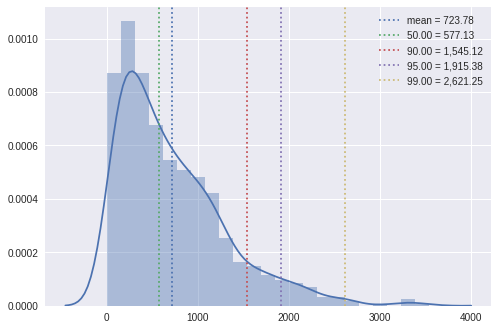

In [6]:
with model:
    pl = elicit("primary_loss", [0, 100, 1005, 1100, 10000])

sumplot(pl.var.rvs(1000))

## Secondary loss

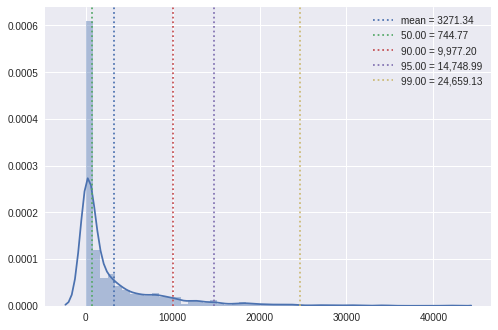

In [7]:
with model:
    sl = elicit("secondary_loss", [0, 10, 105, 50000, 10000])

sumplot(sl.var.rvs(1000))

## Risk

In [0]:
with model:
    risk = mc.Deterministic("risk", pl + sl)

## Simulation

In [9]:
with model:
    trace = mc.sample(seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [secondary_loss_scaled__, primary_loss_scaled__]
100%|██████████| 1000/1000 [00:01<00:00, 919.33it/s]


## Analysis

In [0]:
df = mc.trace_to_dataframe(trace)

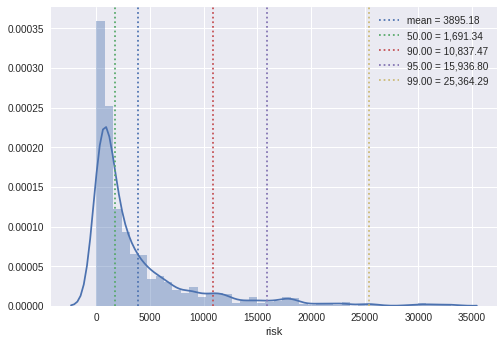

In [12]:
sumplot(df.risk)